In [ ]:
import cv2
import numpy as np

# Load the input panorama image
panorama = cv2.imread('/Volumes/ExFAT2/perception_bias/data/external/triplets_selected/triplet_87/WxDvficPEOBbfqqGhGoEPg.jpg')
cv2.imshow('Original Panorama', panorama)
# Define the amount of shift in pixels
shift_x = 100  # Shift in the horizontal direction
shift_y = 50   # Shift in the vertical direction

# Construct the transformation matrix
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

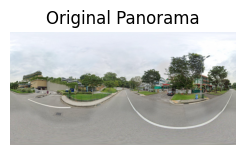

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the input panorama image
panorama = cv2.imread('/Volumes/ExFAT2/perception_bias/data/external/triplets_selected/triplet_87/WxDvficPEOBbfqqGhGoEPg.jpg')
# Original panorama
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Original Panorama')
plt.axis('off')
plt.show()



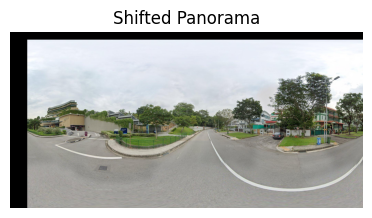

In [2]:
# Define the amount of shift in pixels
shift_x = 100  # Shift in the horizontal direction
shift_y = 50   # Shift in the vertical direction

# Construct the transformation matrix
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

# Apply the warp affine transformation
shifted_panorama = cv2.warpAffine(panorama, M, (panorama.shape[1], panorama.shape[0]))

# Display the original and shifted images using Matplotlib
plt.figure(figsize=(10, 5))


# Shifted panorama
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(shifted_panorama, cv2.COLOR_BGR2RGB))
plt.title('Shifted Panorama')
plt.axis('off')

plt.show()

In [ ]:
# Display the original and shifted images
cv2.imshow('Original Panorama', panorama)
cv2.imshow('Shifted Panorama', shifted_panorama)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
import cv2
import numpy as np

def shift_camera_position(input_image, output_image, dx=0, dy=0, dz=0, dtheta=0, dphi=0):
    # Read the input image
    img = cv2.imread(input_image, cv2.IMREAD_COLOR)
    h, w, _ = img.shape

    # Generate the spherical coordinates
    theta = np.linspace(0, 2*np.pi, w)
    phi = np.linspace(0, np.pi, h)

    # Create a meshgrid for spherical coordinates
    theta, phi = np.meshgrid(theta, phi)

    # Convert spherical coordinates to cartesian coordinates
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    # Apply the shift in position
    x += dx
    y += dy
    z += dz

    # Convert cartesian coordinates back to spherical coordinates
    theta = np.arctan2(y, x) + dtheta
    phi = np.arccos(z / np.sqrt(x**2 + y**2 + z**2)) + dphi

    # Ensuring phi stays within bounds
    phi = np.clip(phi, 0, np.pi)

    # Map the spherical coordinates back to pixel coordinates
    i = ((phi / np.pi) * (h - 1)).astype(int)
    j = ((theta / (2*np.pi)) * (w - 1)).astype(int)

    # Create the output image by sampling from the input image
    output = img[i,j]

    # Save the output image
    cv2.imwrite(output_image, output)


# Use the function to shift the camera position
shift_camera_position('notebooks/input_panorama.jpg', 'notebooks/output_panorama.jpg', dx=0.5, dy=0.5, dz=-0.5, dtheta=0.5, dphi=0)


In [21]:
def panorama_to_perspective(input_image, output_image, shift_phi, fov=90):
    # Read the input image
    img = cv2.imread(input_image, cv2.IMREAD_COLOR)
    h, w, _ = img.shape

    # Step size for theta and phi
    d_theta = 2*np.pi / w
    d_phi = np.pi / h

    # Generate theta and phi values
    theta = np.linspace(0, 2*np.pi, w)
    phi = np.linspace(0, np.pi, h)

    # Create a meshgrid
    theta, phi = np.meshgrid(theta, phi)
    
    # Apply the shift in phi to simulate moving to the roadside
    phi += shift_phi

    # Convert spherical to cartesian coordinates
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    # Define the intrinsic matrix for the perspective projection
    focal_length = (w / 2) / np.tan((fov / 2) * (np.pi / 180))
    K = np.array([[focal_length, 0, w/2, 0],
                  [0, focal_length, h/2, 0],
                  [0, 0, 1, 0]])

    # Convert cartesian coordinates to homogeneous coordinates
    cartesian_coords = np.stack([x, y, z], axis=-1)
    homogeneous_coords = np.concatenate([cartesian_coords, np.ones((h, w, 1))], axis=-1)

    # Project the 3D points onto the 2D image plane
    img_plane_coords = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            img_plane_coords[i, j] = np.dot(K, homogeneous_coords[i, j])

    # Convert from homogeneous coordinates to 2D coordinates
    img_plane_coords = img_plane_coords[...,:2] / img_plane_coords[...,2:]

    # Map the coordinates to pixel values
    i = np.clip(img_plane_coords[...,1], 0, h-1).astype(int)
    j = np.clip(img_plane_coords[...,0], 0, w-1).astype(int)

    # Create the output image by sampling from the input image
    output = img[i, j]

    # Save the output image
    cv2.imwrite(output_image, output)

# Example usage:
panorama_to_perspective('notebooks/input_panorama.jpg', 'notebooks/output_perspective.jpg', shift_phi=0.1, fov=90)


In [35]:
import cv2
import numpy as np

def xyz2lonlat(xyz):
    lon = np.arctan2(xyz[..., 1], xyz[..., 0])
    lat = np.arctan2(xyz[..., 2], np.sqrt(xyz[..., 0]**2 + xyz[..., 1]**2))
    return np.stack([lon, lat], axis=-1)

def lonlat2XY(lonlat, shape):
    h, w, _ = shape
    x = (lonlat[..., 0] + np.pi) * w / (2*np.pi)
    y = (-lonlat[..., 1] + np.pi / 2) * h / np.pi
    return np.stack([x, y], axis=-1)

def panorama_to_perspective(input_image, output_image, FOV, THETA, PHI, height, width, lateral_shift=0.0):
    # Read the input image
    img = cv2.imread(input_image, cv2.IMREAD_COLOR)

    # Define intrinsic matrix and its inverse
    f = 0.5 * width / np.tan(0.5 * FOV / 180.0 * np.pi)
    cx = (width - 1) / 2.0
    cy = (height - 1) / 2.0
    K = np.array([
        [f, 0, cx],
        [0, f, cy],
        [0, 0, 1],
    ], np.float32)
    K_inv = np.linalg.inv(K)

    # Generate meshgrid
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    z = np.ones_like(x)
    xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)

    # Project 2D image coordinates to 3D coordinates
    xyz = xyz @ K_inv.T

    # Apply lateral shift (translate along the X-axis)
    xyz[..., 0] += lateral_shift

    # Apply rotations
    y_axis = np.array([0.0, 1.0, 0.0], np.float32)
    x_axis = np.array([1.0, 0.0, 0.0], np.float32)
    R1, _ = cv2.Rodrigues(y_axis * np.radians(THETA))
    R2, _ = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(PHI))
    R = R2 @ R1
    xyz = xyz @ R.T

    # Convert to spherical coordinates
    lonlat = xyz2lonlat(xyz)

    # Convert back to 2D image coordinates and sample from input image
    XY = lonlat2XY(lonlat, shape=img.shape).astype(np.float32)
    persp = cv2.remap(img, XY[..., 0], XY[..., 1], cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)

    # Save the output image
    cv2.imwrite(output_image, persp)

# Example usage:
panorama_to_perspective('notebooks/input_panorama.jpg', 'notebooks/output_perspective.jpg', FOV=90, THETA=0, PHI=0, height=800, width=800, lateral_shift=-0.5)



In [50]:
def panorama_to_perspective(input_image, output_image, FOV, THETA, PHI, height, width, lateral_shift=0.0):
    # Read the input image
    img = cv2.imread(input_image, cv2.IMREAD_COLOR)

    # Define intrinsic matrix and its inverse
    f = 0.5 * width / np.tan(0.5 * FOV / 180.0 * np.pi)
    cx = (width - 1) / 2.0
    cy = (height - 1) / 2.0
    K = np.array([
        [f, 0, cx],
        [0, f, cy],
        [0, 0, 1],
    ], np.float32)
    K_inv = np.linalg.inv(K)

    # Generate meshgrid
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    z = np.ones_like(x)
    xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)

    # Project 2D image coordinates to 3D coordinates
    xyz = xyz @ K_inv.T

    # Adjust the rotation axes to rotate around the X and Y axes
    x_axis = np.array([1.0, 0.0, 0.0], np.float32)
    y_axis = np.array([0.0, 1.0, 0.0], np.float32)
    
    # Calculate the rotation matrices
    R1, _ = cv2.Rodrigues(x_axis * np.radians(PHI))
    R2, _ = cv2.Rodrigues(y_axis * np.radians(THETA))
    R = R2 @ R1
    
    # Apply rotations and lateral shift
    xyz = xyz @ R.T
    xyz[..., 0] += lateral_shift

    # Convert to spherical coordinates
    lonlat = xyz2lonlat(xyz)

    # Convert back to 2D image coordinates and sample from input image
    XY = lonlat2XY(lonlat, shape=img.shape).astype(np.float32)
    persp = cv2.remap(img, XY[..., 0], XY[..., 1], cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)

    # Save the output image
    cv2.imwrite(output_image, persp)

# Example usage:
panorama_to_perspective('notebooks/input_panorama.jpg', 'notebooks/output_perspective.jpg', FOV=90, THETA=0, PHI=90, height=800, width=800, lateral_shift=1)


In [10]:
import cv2
import numpy as np

def xyz2lonlat(xyz):
    atan2 = np.arctan2
    asin = np.arcsin

    norm = np.linalg.norm(xyz, axis=-1, keepdims=True)
    xyz_norm = xyz / norm
    x = xyz_norm[..., 0:1]
    y = xyz_norm[..., 1:2]
    z = xyz_norm[..., 2:]

    lon = atan2(x, z)
    lat = asin(y)
    lst = [lon, lat]

    out = np.concatenate(lst, axis=-1)
    return out


def lonlat2XY(lonlat, shape):
    X = (lonlat[..., 0:1] / (2 * np.pi) + 0.5) * (shape[1] - 1)
    Y = (lonlat[..., 1:] / (np.pi) + 0.5) * (shape[0] - 1)
    lst = [X, Y]
    out = np.concatenate(lst, axis=-1)

    return out

def get_perspective(img, FOV, THETA, PHI, height, width):
    #
    # THETA is left/right angle, PHI is up/down angle, both in degree
    #

    f = 0.5 * width * 1 / np.tan(0.5 * FOV / 180.0 * np.pi)
    cx = (width - 1) / 2.0
    cy = (height - 1) / 2.0
    K = np.array([
        [f, 0, cx],
        [0, f, cy],
        [0, 0, 1],
    ], np.float32)
    K_inv = np.linalg.inv(K)

    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    z = np.ones_like(x)
    xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)
    xyz = xyz @ K_inv.T

    y_axis = np.array([0.0, 1.0, 0.0], np.float32)
    x_axis = np.array([1.0, 0.0, 0.0], np.float32)
    R1, _ = cv2.Rodrigues(y_axis * np.radians(THETA))
    R2, _ = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(PHI))
    R = R2 @ R1
    xyz = xyz @ R.T
    lonlat = xyz2lonlat(xyz)
    XY = lonlat2XY(lonlat, shape=img.shape).astype(np.float32)
    persp = cv2.remap(img, XY[..., 0], XY[..., 1], cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
    return persp

def shift_camera_position(img, lateral_shift, vertical_shift, rotation_angle, height, width):
    # Camera intrinsic matrix
    f = 0.5 * width / np.tan(0.5 * 90 / 180.0 * np.pi)
    cx = (width - 1) / 2.0
    cy = (height - 1) / 2.0
    K = np.array([
        [f, 0, cx],
        [0, f, cy],
        [0, 0, 1],
    ], np.float32)
    K_inv = np.linalg.inv(K)

    # Create 3D points from the 2D image coordinates
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    z = np.ones_like(x)
    xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)
    xyz = xyz @ K_inv.T
    
        # Rotation matrices
    y_axis = np.array([0.0, 1.0, 0.0], np.float32)
    x_axis = np.array([1.0, 0.0, 0.0], np.float32)
    R1, _ = cv2.Rodrigues(y_axis * np.radians(rotation_angle))
    R2, _ = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(0))
    R = R2 @ R1
    
    # Extend rotation matrix to a 4x4 matrix
    R = np.vstack([np.hstack([R, np.zeros((3, 1))]), np.array([0, 0, 0, 1])])
    
    # Translation matrix
    T = np.array([
        [1, 0, 0, lateral_shift],
        [0, 1, 0, vertical_shift],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ], np.float32)
    
    # Apply rotation and translation to the coordinates
    homogeneous_coords = np.concatenate([xyz, np.ones((height, width, 1))], axis=-1)
    transformed_coords = homogeneous_coords @ (R @ T).T


    # Convert transformed coordinates to lonlat and then to image coordinates
    lonlat = xyz2lonlat(transformed_coords[...,:3])
    XY = lonlat2XY(lonlat, shape=img.shape).astype(np.float32)
    shifted_img = cv2.remap(img, XY[..., 0], XY[..., 1], cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
    
    return shifted_img

# Assuming you have your panorama image loaded as 'panorama_img'
perspective_img = get_perspective(cv2.imread('notebooks/input_panorama.jpg'), FOV=120, THETA=0, PHI=0, height=800, width=800)

# Apply camera shift
output_img = shift_camera_position(perspective_img, lateral_shift=0, vertical_shift=0, rotation_angle=0, height=800, width=800)

# Save the output image
cv2.imwrite('notebooks/output_image.jpg', output_img)
cv2.imwrite('notebooks/output_perspective.jpg', perspective_img)


True

In [15]:
def shift_camera_position_in_panorama(img, shift_phi, shift_theta):
    height, width = img.shape[:2]
    
    # Generate new latitude and longitude values with the shifts
    theta, phi = np.meshgrid(
        np.linspace(0, 2*np.pi, width),
        np.linspace(0, np.pi, height)
    )
    
    theta += shift_theta
    phi += shift_phi
    
    # Convert theta and phi to image coordinates
    x = (theta / (2*np.pi)) * width
    y = (phi / np.pi) * height
    
    # Use remap to apply the transformation to the image
    return cv2.remap(img, x.astype(np.float32), y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)


import cv2
import numpy as np

def panorama_to_point_cloud(img):
    h, w = img.shape[:2]
    theta, phi = np.meshgrid(np.linspace(0, 2*np.pi, w), np.linspace(0, np.pi, h))
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.stack([x, y, z], axis=-1)

def point_cloud_to_panorama(point_cloud):
    x, y, z = point_cloud[...,0], point_cloud[...,1], point_cloud[...,2]
    theta = np.arctan2(y, x)
    phi = np.arccos(z / np.sqrt(x*x + y*y + z*z))
    return theta, phi

def shift_camera_position(img, dx, dy, dz):
    # Step 1: Convert panorama to point cloud
    point_cloud = panorama_to_point_cloud(img)
    
    # Step 2: Shift the camera position
    h, w, _ = img.shape
    translation_matrix = np.array([
        [1, 0, 0, dx],
        [0, 1, 0, dy],
        [0, 0, 1, dz],
        [0, 0, 0, 1]
    ])
    homogeneous_coords = np.concatenate([point_cloud, np.ones((h, w, 1))], axis=-1)
    transformed_coords = np.dot(homogeneous_coords, translation_matrix.T)[..., :3]
    
    # Step 3: Convert point cloud back to panorama
    theta, phi = point_cloud_to_panorama(transformed_coords)
    
    return theta, phi

# Example usage:
img = cv2.imread('notebooks/input_panorama.jpg')
theta, phi = shift_camera_position(img, dx=-0.5, dy=0, dz=-0.1)

# Load the panorama image
pano_img = cv2.imread('notebooks/input_panorama.jpg')

# Shift the camera position in the panorama
shifted_pano_img = shift_camera_position_in_panorama(pano_img, shift_phi=phi, shift_theta=theta)

# Create a perspective image from the shifted panorama
perspective_img = get_perspective(shifted_pano_img, FOV=90, THETA=0, PHI=0, height=800, width=800)

# Save the resulting image
cv2.imwrite('notebooks/output_perspective.jpg', perspective_img)
cv2.imwrite('notebooks/output_shifted.jpg', shifted_pano_img)

True

In [22]:
import cv2
import numpy as np

def panorama_to_point_cloud(img):
    h, w = img.shape[:2]
    theta, phi = np.meshgrid(np.linspace(0, 2*np.pi, w), np.linspace(0, np.pi, h))
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.stack([x, y, z], axis=-1)

def point_cloud_to_panorama(point_cloud, f, width, height):
    x, y, z = point_cloud[...,0], point_cloud[...,1], point_cloud[...,2]

    # Perspective projection formulae:
    u = -f * x / z + width / 2
    v = -f * y / z + height / 2

    # Normalize theta and phi to lie within the image bounds
    u = np.clip(u, 0, width-1)
    v = np.clip(v, 0, height-1)
    
    return u, v

def shift_camera_position(img, dx, dy, dz, f):
    # Step 1: Convert panorama to point cloud
    point_cloud = panorama_to_point_cloud(img)
    
    # Step 2: Shift the camera position
    h, w, _ = img.shape
    translation_matrix = np.array([
        [1, 0, 0, dx],
        [0, 1, 0, dy],
        [0, 0, 1, dz],
        [0, 0, 0, 1]
    ])
    homogeneous_coords = np.concatenate([point_cloud, np.ones((h, w, 1))], axis=-1)
    transformed_coords = np.dot(homogeneous_coords, translation_matrix.T)[..., :3]
    
    # Step 3: Convert point cloud back to panorama with perspective projection
    u, v = point_cloud_to_panorama(transformed_coords, f, w, h)
    
    # Remap the image
    output_img = cv2.remap(img, u.astype(np.float32), v.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
    
    return output_img

# Example usage:
img = cv2.imread('notebooks/input_panorama.jpg')
f = 50  # Focal length in pixels (you might need to adjust this value)
output_img = shift_camera_position(img, dx=0.1, dy=0.1, dz=0.1, f=f)
cv2.imwrite('notebooks/output_perspective.jpg', output_img)


True

In [42]:
import numpy as np
import cv2

def panorama_to_point_cloud(img):
    h, w = img.shape[:2]
    theta, phi = np.meshgrid(np.linspace(0, 2*np.pi, w), np.linspace(0, np.pi, h))
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.stack([x, y, z], axis=-1)

def point_cloud_to_panorama(point_cloud, width, height):
    x, y, z = point_cloud[...,0], point_cloud[...,1], point_cloud[...,2]
    theta = np.arctan2(y, x)
    phi = np.arccos(z / np.sqrt(x**2 + y**2 + z**2))
    u = ((theta + np.pi) / (2 * np.pi)) * (width - 1)
    v = (phi / np.pi) * (height - 1)
    return u, v

def shift_camera_position(img, lateral_shift=0.0, vertical_shift=0.0, depth_shift=0.0, focal_length=1.0):
    # Convert panorama to point cloud
    point_cloud = panorama_to_point_cloud(img)

    # Define camera intrinsic matrix
    height, width, _ = img.shape
    cx, cy = width / 2, height / 2
    K = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ])

    # Define camera extrinsic matrix
    T = np.eye(4)
    T[0, 3] = lateral_shift
    T[1, 3] = vertical_shift
    T[2, 3] = depth_shift

    # Transform point cloud using camera parameters
    homogeneous_coords = np.concatenate([point_cloud, np.ones((height, width, 1))], axis=-1)
    transformed_coords = homogeneous_coords @ T.T

    # Project point cloud back to 2D image using intrinsic matrix
    projected_coords = transformed_coords[...,:3] @ K.T
    u = projected_coords[...,0] / projected_coords[...,2]
    v = projected_coords[...,1] / projected_coords[...,2]

    # Remap the image
    output_img = cv2.remap(img, u.astype(np.float32), v.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
    
    return output_img


# Example usage:
img = cv2.imread('notebooks/input_panorama.jpg')
output_img = shift_camera_position(img, lateral_shift=0.0, vertical_shift=0.0, depth_shift=0.0, focal_length=90)
cv2.imwrite('notebooks/output_perspective.jpg', output_img)


True

In [36]:
import numpy as np

def estimate_focal_length(image_width, fov_degrees):
    """
    Estimate the focal length of the camera given the image width and field of view.

    :param image_width: Width of the image (or panorama) in pixels.
    :param fov_degrees: Field of view of the camera in degrees.
    :return: Estimated focal length.
    """
    fov_radians = np.radians(fov_degrees)
    focal_length = image_width / (2 * np.tan(fov_radians / 2))
    return focal_length

# Usage:
image_width = 800  # Replace with the actual width of your image
fov_degrees = 120  # Replace with the actual FOV of your camera
focal_length = estimate_focal_length(image_width, fov_degrees)
print(f"Focal length: {focal_length} pixels")


Focal length: 230.94010767585038 pixels
